In [45]:
from scipy.integrate import quad
import scipy.stats as stats 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [46]:
#from frbcat import Frbcat
#from convenience import plot_aa_style, rel_path

SCALE = 'log'

def import_frbcat():
    """Gather rate data."""
    cat = Frbcat()
    cat.clean()
    cat.filter(one_offs=False,
               repeaters=True,
               repeat_bursts=True,
               one_entry_per_frb=True)
    df = cat.df

    # Remove Pushichino events
    df = df[~df.telescope.str.startswith('pushchino')]

    # Keep CHIME
    df = df[df.telescope.str.startswith('chime')]

    # Collate exposure time information
    #              Name, Number of Bursts, Exposure [h]
    rep_data = {'FRB180725.J0613+67': [np.nan, np.nan],
                'FRB180814.J0422+73': [3, 14],
                'FRB180908.J1232+74': [4, (.5*(53+36))],
                'FRB180916.J0158+65': [10, 23],
                'FRB181017.J1705+68': [2, 20],
                'FRB181017.J18+81': [3, (.5*(55+159))],
                'FRB181030.J1054+73': [2, (.5*(27+19))],
                'FRB181119.J12+65': [3, 19],
                'FRB181128.J0456+63': [2, 16],
                'FRB190110.J1353+48': [3, 23],
                'FRB190116.J1249+27': [2, 8],
                'FRB190117.J2207+17': [5, 19],
                'FRB190208.J1855+46': [2, 20],
                'FRB190209.J0937+77': [2, (.5*(34+28))],
                'FRB190212.J02+20': [2, 17],
                'FRB190222.J2052+69': [2, 20],
                'FRB190417.J1939+59': [3, 29],
                'FRB190604.J1435+53': [2, 30],
                'FRB190907.J08+46': [3, 23]}
    db = pd.DataFrame(rep_data, index=['n_bursts', 'exposure']).T
    db['rate'] = db.n_bursts / db.exposure
    db['frb_name'] = db.index

    # Add info to frbcat
    df['rate'] = np.nan
    for name, row in db.iterrows():
        df.loc[df.frb_name == name, 'rate'] = row.rate
        df.loc[df.frb_name == name, 'n_bursts'] = row.n_bursts
        df.loc[df.frb_name == name, 'exposure'] = row.exposure

    return df

def poisson_interval(k, sigma=1):
    """
    Use chi-squared info to get the poisson interval.

    Given a number of observed events, which range of observed events would
    have been just as likely given a particular interval?

    Based off https://stackoverflow.com/questions/14813530/
    poisson-confidence-interval-with-numpy
    """
    gauss = stats.norm(0, 1).pdf
    a = 1 - quad(gauss, -sigma, sigma, limit=1000)[0]
    low, high = (stats.chi2.ppf(a/2, 2*k) / 2, stats.chi2.ppf(1-a/2, 2*k + 2) / 2)
    if isinstance(k, np.ndarray):
        low[k == 0] = 0.
    elif k == 0:
        low = 0.0

    return low, high

def plot_w_eff_rate(df):
    """Plot effective pulse width against rate."""
    plot_aa_style(cols=1)

    df = df.sort_values('utc')

    # Groupby repeater
    db = df.groupby(['frb_name']).mean()
    width = db.width
    n_bursts = db.n_bursts
    rate = db.rate
    exposure = db.exposure.to_numpy()

    print(n_bursts)

    # Calculate error bars
    low, high = poisson_interval(n_bursts.to_numpy(), sigma=1)
    errors = (low/exposure, high/exposure)
    print(errors)
    # Plot values
    plt.errorbar(width, rate, yerr=errors, marker='x', fmt='o')

    plt.xlabel(r'Mean Pulse Width (ms)')
    plt.ylabel(r'Rate (/hour)')

    if SCALE == 'log':
        plt.xscale('log')
        plt.yscale('log', nonposy='clip')

    plt.tight_layout()
    plt.savefig(rel_path('./plots/w_eff_rate_frbcat.pdf'))


# if __name__ == '__main__':
#     df = import_frbcat()
#     plot_w_eff_rate(df)

In [47]:
def gen_beamed_frbs(nfrb=5e4, Tobs=10.0, Nrepeat_bursts=1000,
                    beaming_dist='uniform', 
                    period_dist='delta', dimensions=2):
    """ Generate a population of repeating, beamed FRBs
    and count detection statistics in observing window
    
    Paramters:
    ---------
    nfrb : int/float
        Number of FRB-emitting sources to simulate
    Tobs : float 
        Observing time in seconds
    Nrepeat_bursts: int 
        Number of repeat bursts per source (should be larger than Tobs)
    beaming_dist : str
        Distribution of beaming angles 
        (uniform, delta, lognormal, int/float for cumulative power-law)
    period_dist : str
        Distribution of repeat periods
        (uniform, delta, gaussian)
    dimesions : int 
        if 1 simulate beaming between 0 and 2pi
        if 2 simulate on sphere
        
    Returns:
    -------
    n_detected_tot:
        Length nfrb list of observable bursts from each source
    omega:
        Intrinsic distribution of open angles
    n_of_p:
        Intrinsic distribution of repeat periods (n(1/\mathcal{R}))
    """
    nfrb = int(nfrb)
    if dimensions==1:
        C = 2*np.pi
    elif dimensions==2:
        C = 4*np.pi
    else:
        print("Expected 1 or 2 dimensions")
        
    if beaming_dist=='uniform':
        # assume beaming fractions go from 0 to 1
        omega = np.random.uniform(0, C, nfrb)
    elif beaming_dist=='delta':
        omega = np.ones([nfrb])
    elif beaming_dist=='lognormal':
        omega = np.random.lognormal(np.log(2.0*10**-1/5.0),1.5,2*nfrb)
        omega = omega[omega<C][:nfrb]
    elif type(beaming_dist) in (float, int):
        omega = np.random.uniform(0, 1, nfrb)**(1./beaming_dist)
        # normalise omega such that max is 10 times mean value
        omega = omega / omega.max() * C
    else:
        print("expected known beaming_dist")
        return
    
    if period_dist=='uniform':
        n_of_p = 2*np.random.uniform(0, 1, nfrb)
    elif period_dist=='delta':
        n_of_p = 2*np.ones([nfrb])
    elif type(period_dist)==int:
        n_of_p = np.random.uniform(0, 1, nfrb)**(1./period_dist)
    elif period_dist=='gaussian':
        n_of_p = np.random.normal(1, 0.05, 2*nfrb)
        n_of_p = n_of_p[n_of_p>0][:nfrb]

    n_detected_tot = []
    Tobs_arr = []
    # define arbitrary line of sight
    pointing = 0.0
    width_detected_full = []
    for ii in range(nfrb):
        Tobs = np.random.uniform(20, 30)
        Tobs_arr.append(Tobs)
        # Calculate times of arrival (toa) for iith frb, up to 1000 repeats
        toas = np.cumsum(np.random.exponential(n_of_p[ii], 1000))    
        n_repeats = len(np.where(toas<Tobs)[0])
        n_detected = 0
        width_detected = []
        for jj in range(n_repeats):
            # 1 dimension, assuming azimuthal symmetry
            if dimensions==1:
                frb_angle = np.random.uniform(0,2*np.pi)
                if np.mod(np.abs(pointing-frb_angle),np.pi)<(omega[ii]/2.):
                    n_detected += 1
            # 2 dimensions, assuming on sphere
            elif dimensions==2:
                # Assume observer is at 
                th_k, phi_k = 0., 0.
                # Get 2D pointing of FRB
                th_frb, phi_frb = np.random.uniform(0,2*np.pi), np.random.uniform(0,np.pi)
                sep = np.arccos(np.sin(th_k)*np.sin(th_frb) + np.cos(th_k)*np.cos(th_frb)*np.cos(phi_k-phi_frb))
                # Test if FRB is pointed in observer's direction
                if sep < np.sqrt(omega[ii]/np.pi):
                    n_detected += 1
                    wwii=omega[ii]*1e-3*5+1e-3*5*np.random.normal(0, 0.25*omega[ii])
                    width_detected.append(wwii)
        width_detected_full.append(width_detected)
                    
        n_detected_tot.append(n_detected)
        
    return n_detected_tot, omega, n_of_p, Tobs_arr, width_detected_full

def get_rep_ind(n_detected_tot):
    """ Get indexes of sources that were 
    detected once (no_rep_ind) and more than 
    once (rep_ind)
    """
    rep_ind, no_rep_ind = [], []
    for ii in range(len(n_detected_tot)):
        if n_detected_tot[ii]>1:
            rep_ind.append(ii)
        elif n_detected_tot[ii]==1:
            no_rep_ind.append(ii)

    return rep_ind, no_rep_ind

def detect_frb(omega, rep_ind, no_rep_ind, tsamp=9.83e-4, 
               dnu_MHz=400.0/16384, nu_GHZ=0.6, jitter=None,
               DM = 1000.0, smin=0.1, f=5):
    """ Given an array of FRB opening angles (omega) and indexes for 
    when those bursts were observable (rep_ind and no_rep_ind), 
    apply instrumental smearing effects
    
    Parameters:
    ----------
    omega : array
        array of opening angles 
    rep_ind : list 
        list of indexes of FRBs that have more than one observable burst
    no_rep_ind : list 
        list of indexes of FRBs that were observable only once
    tsamp : float 
        sampling time of instrument in seconds
    dnu_MHz: float 
        channel width in MHz
    nu_GHz : float 
        central frequency in GHz
    jitter : bool
        If None, there is no noise in the t/omega relation. 
        If jitter is a number, add Gaussian noise to t/omega 
        relation using sigma=jitter
    DM : float 
        dispersion measure used for dipsersion smearing
    
    Returns:
    -------
    tobs_norep: 
        widths of once-off detections
    tobs_rep: 
        widths of detected repeaters    
    """

    if jitter is not None:
        width_omega_corr = jitter
    else:
        width_omega_corr = 0.0
        
    omega_norep = omega[no_rep_ind]
    omega_rep = omega[rep_ind]
    widths = (omega+width_omega_corr*np.random.normal(0,1,len(omega)))*f*1e-3
    widths_norep = omega_norep*f*1e-3
    widths_rep = omega_rep*f*1e-3

    tDM = 8.3e-6 * DM * dnu_MHz / nu_GHZ**3
    tobs = np.sqrt(tsamp**2 + tDM**2 + widths**2)
    flux = np.random.uniform(0,1,len(omega))**-(1/1.5)
    snr = flux * (widths / tobs)**0.5
    detection_ind = np.where(snr>smin)[0]
    detection_norep_ind = list(set(detection_ind) & set(no_rep_ind))
    detection_rep_ind = list(set(detection_ind) & set(rep_ind))
    print(tDM, widths.min(), tobs.min())
    tobs_norep = tobs[detection_norep_ind]
    tobs_rep = tobs[detection_rep_ind]
    
    return tobs_norep, tobs_rep, detection_norep_ind, detection_rep_ind

def detect_frb_width(omega, rep_ind, no_rep_ind, width_observable=None, tsamp=9.83e-4, 
               dnu_MHz=400.0/16384, nu_GHZ=0.6, jitter=None,
               DM = 1000.0, smin=0.1, f=5):
    """ Given an array of FRB opening angles (omega) and indexes for 
    when those bursts were observable (rep_ind and no_rep_ind), 
    apply instrumental smearing effects
    
    Parameters:
    ----------
    omega : array
        array of opening angles 
    rep_ind : list 
        list of indexes of FRBs that have more than one observable burst
    no_rep_ind : list 
        list of indexes of FRBs that were observable only once
    tsamp : float 
        sampling time of instrument in seconds
    dnu_MHz: float 
        channel width in MHz
    nu_GHz : float 
        central frequency in GHz
    jitter : bool
        If None, there is no noise in the t/omega relation. 
        If jitter is a number, add Gaussian noise to t/omega 
        relation using sigma=jitter
    DM : float 
        dispersion measure used for dipsersion smearing
    
    Returns:
    -------
    tobs_norep: 
        widths of once-off detections
    tobs_rep: 
        widths of detected repeaters    
    """

    if jitter is not None:
        width_omega_corr = jitter
    else:
        width_omega_corr = 0.0
        
    omega_norep = omega[no_rep_ind]
    omega_rep = omega[rep_ind]
    widths = (omega+width_omega_corr*np.random.normal(0,1,len(omega)))*f*1e-3
    widths_norep = omega_norep*f*1e-3
    widths_rep = omega_rep*f*1e-3
    tDM = 8.3e-6 * DM * dnu_MHz / nu_GHZ**3
    flux = np.random.uniform(0,1,len(omega))**-(1/1.5)
    
    if width_observable is not None:
        tobs_rep, tobs_norep = [], []
        for ii in rep_ind:
            widths = np.array(width_observable[ii])
            flux_ii = flux[ii]
            tobs = np.sqrt(tsamp**2 + tDM**2 + widths**2)
            snr_ii = flux_ii * (widths / tobs)**0.5
            detection_ind = np.where(snr_ii>smin)[0]
            if len(detection_ind)>0:
                tobs_rep.append(tobs[detection_ind])
        for jj in no_rep_ind:
            widths = np.array(width_observable[jj])
            flux_jj = flux[jj]
            tobs = np.sqrt(tsamp**2 + tDM**2 + widths**2)
            snr_jj = flux_jj * (widths / tobs)**0.5
            detection_ind = np.where(snr_jj>smin)[0]
#            tobs_norep.append(tobs[detection_ind])   
            if len(detection_ind)>0:
                tobs_norep.append(tobs[detection_ind])
    
        return tobs_norep, tobs_rep, None, None
    
    tobs = np.sqrt(tsamp**2 + tDM**2 + widths**2)
    flux = np.random.uniform(0,1,len(omega))**-(1/1.5)
    snr = flux * (widths / tobs)**0.5
    detection_ind = np.where(snr>smin)[0]
    detection_norep_ind = list(set(detection_ind) & set(no_rep_ind))
    detection_rep_ind = list(set(detection_ind) & set(rep_ind))
    print(tDM, widths.min(), tobs.min())
    tobs_norep = tobs[detection_norep_ind]
    tobs_rep = tobs[detection_rep_ind]
    
    return tobs_norep, tobs_rep, detection_norep_ind, detection_rep_ind

In [48]:
# Simulate N beamed FRBs with some distribution of 
# beaming angles and average repetition interval (period_dist)
N=100000
beaming_dist='lognormal'
period_dist='delta'
n_detected_tot, omega, n_of_p, Tobs_arr, wdet = gen_beamed_frbs(beaming_dist=beaming_dist, 
                                                          period_dist=period_dist, nfrb=N, 
                                                          dimensions=2)

# Get indexes of repeaters (rep_ind) and once-off sources (no_rep_ind)
rep_ind, no_rep_ind = get_rep_ind(n_detected_tot)

# Convert beaming angles to pulse widths and 
# calculate which will be detected after instrumental smearing
_ = detect_frb(omega, rep_ind, no_rep_ind, tsamp=9.83e-4, 
               dnu_MHz=400.0/16384, nu_GHZ=0.6, jitter=0.0,
               DM = 1000.0, smin=0.75)

tobs_norep, tobs_rep, detection_norep_ind, detection_rep_ind = _

0.000938132957175926 1.2658760304967447e-07 0.001358816566488674


In [49]:
_ = detect_frb_width(omega, rep_ind, no_rep_ind, width_observable=wdet, 
                     tsamp=9.83e-4, dnu_MHz=400.0/16384, nu_GHZ=0.6, jitter=0.0,
                     DM = 1000.0, smin=0.75)

tobs_norep_, tobs_rep_, detection_norep_ind, detection_rep_ind = _

In [50]:
tobs_rep_ = np.concatenate(tobs_rep_)
tobs_norep_ = np.concatenate(tobs_norep_)

/usr/local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


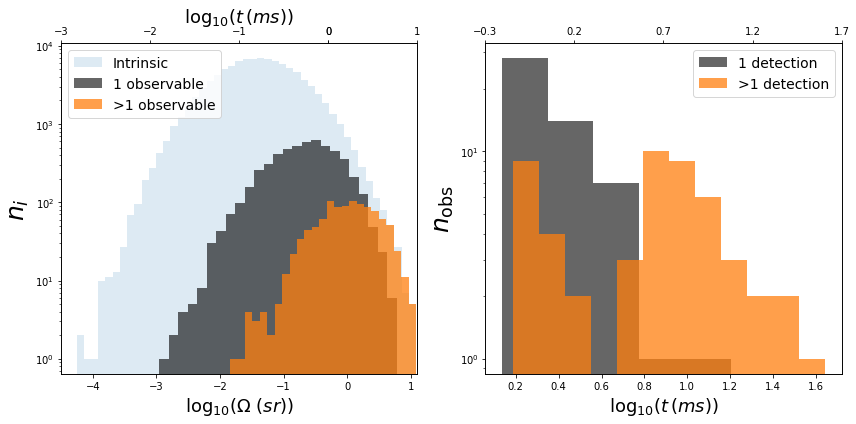

In [51]:
cum=False
normalize=False
log=True
fplot=0.05

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = ax1.twiny()

# Make histograms of instrinsic opening angle distributions 
# for all sources, once-off events, and repeaters 
# before "detection" and smearing effects are included
_=ax1.hist(np.log10(omega), log=log, cumulative=cum, 
           bins=50, alpha=0.15, normed=normalize)
_=ax1.hist(np.log10(omega[no_rep_ind]), cumulative=cum, log=log, 
           bins=25, alpha=0.6, normed=normalize, color='k')
_=ax1.hist(np.log10(omega[rep_ind]), cumulative=cum, log=log, 
           bins=25, alpha=0.75, normed=normalize, color='C1')

ax1.set_xlabel(r'$\log_{10}(\Omega \,\,(sr))$', fontsize=18)
ax1.legend(['Intrinsic','1 observable','>1 observable'], fontsize=14, loc=2)
ax1.set_ylabel(r'$n_i$', fontsize=25)
ax1.set_xticks([-4, -3, -2, -1, 0, 1])
ax1.set_xlim(-4.5, 1.1)

ax2.set_xlabel(r'$\log_{10}(t\,(ms))$', fontsize=18)
ax2.set_xticks((np.array([-4, -3, -2, -1, 0, 1])+np.log10(5)).astype(int))

# Make histogram of once-off detections vs. repeaters 
# in both width and opening angle \Omega
ax1 = fig.add_subplot(122)
ax2 = ax1.twiny()

ax1.set_xlabel(r'$\log_{10}(\Omega \,\,(sr))$', fontsize=18)
ax1.set_ylabel(r'$n_{\rm obs}$', fontsize=25)

plot_ind_norep = (np.random.uniform(0, len(tobs_norep), int(fplot*len(tobs_rep)))).astype(int)
plot_ind_rep = (np.random.uniform(0, len(tobs_rep), int(fplot*len(tobs_rep)))).astype(int)
omega_norep = tobs_norep/(5.0*1e-3)
omega_rep = tobs_rep/(5.0*1e-3)

_=ax1.hist(np.log10(tobs_norep_*1e3)[plot_ind_norep], cumulative=cum, 
           log=log, bins=5, normed=normalize, color='k', alpha=0.6)
_=ax1.hist(np.log10(tobs_rep_*1e3)[plot_ind_rep], cumulative=cum, 
           log=log, bins=12, normed=normalize, color='C1', alpha=0.75)

ax1.set_xlabel(r'$\log_{10}(t\,(ms))$', fontsize=18)
ax2.set_xticks(np.round((np.array([-1, -0.5, 0, 0.5, 1])+np.log10(5)),2))
ax1.legend(['1 detection','>1 detection'], fontsize=14)

plt.tight_layout()

/usr/local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:871: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


ValueError: x and y must have same first dimension, but have shapes (1023,) and (1, 100000)

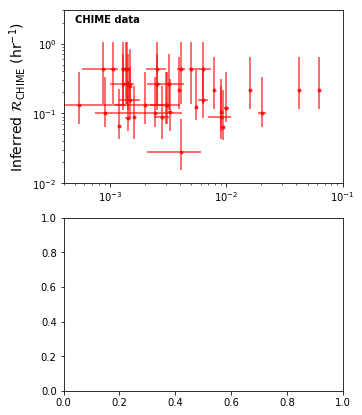

In [52]:
fn='/Users/connor/Downloads/chime_rep_width.csv'
x = pd.read_csv(fn)
x = x.drop(3)
werr_chime = (x.w_eff_lower_err.values*1e-3, x.w_eff_upper_err.values*1e-3)

fig = figure(figsize=(5,7))
subplot(211)
rep_rate_CHIME = N_CHIME / Tobs_CHIME
low, high = poisson_interval(N_CHIME, sigma=1)
errors_CHIME = (low/Tobs_CHIME, high/Tobs_CHIME)
errorbar(width_CHIME*1e-3, rep_rate_CHIME, errors_CHIME, xerr=werr_chime, linestyle='',marker='.', c='red', alpha=0.75)
loglog()
ylim(1e-2, 3e0)
xlim(4e-4, 1e-1)
ylabel(r"Inferred $\mathcal{R}_{\rm CHIME}$ (hr$^{-1}$)", fontsize=14)
text(5e-4, 2, 'CHIME data', weight='bold')

Nplot=19
subplot(212)
# Number of repeat pulses from each repeater source
Ndet = np.array(n_detected_tot)[detection_rep_ind]
Tobs_det = np.array(Tobs_arr)[detection_rep_ind]
Nerr = 1/np.sqrt(Ndet)/Tobs_det
# Apparent repetition rate = N / Tobs
rate_obs_rep = Ndet/Tobs_det
low, high = poisson_interval(Ndet[:Nplot])
Nerr = (low/Tobs_det[:Nplot], high/Tobs_det[:Nplot])
plot(tobs_rep[:], rate_obs_rep[:],'o',c='k',markersize=1, alpha=0.35)
errorbar(tobs_rep[:Nplot], rate_obs_rep[:Nplot], Nerr, linestyle='',marker='.', c='C1', alpha=0.75)
#xlim(0.0013, 0.01)
semilogx()
xlabel(r"$t_{\rm obs}$ (ms)", fontsize=14)
ylabel(r"Inferred $\mathcal{R}_{\rm sim}$ (hr$^{-1}$)", fontsize=14)
legend(['All detectable', '19 detections'], loc=4)
#plot(5*omega, 0.5*omega/(4*np.pi)*np.array(Tobs_arr).mean())
xlim(4e-4, 1e-1)
loglog()
print(len(tobs_rep), len(omega))
ylim(2e-2, 2e0)
text(5e-4, 1.5, 'Simulated data', weight='bold')
tight_layout()
#plt.savefig('./chime_repeat_rate_v2.pdf')

In [ ]:
print("Plotting the probability that a \
       source with some opening angle will \
       be pointing towards the observer once or \
       more than once,for two different repetition rates.")

matplotlib.rcParams['font.monospace'] = ['Source Han Sans TW', 'sans-serif']
fig = plt.figure(figsize=(13,5))
omega = np.logspace(-3,np.log10(4*np.pi),100000)
R = 5
T_obs = 1

# pre-compute poissonian probabilities for n=0, 1, greater than 2
p_1 = np.exp(-omega/(2*np.pi)*T_obs*R)*omega/(2*np.pi)*R*T_obs
p_0 = np.exp(-omega/(2*np.pi)*T_obs*R)
p_gt2 = 1 - p_0 - p_1

# pre-compute same probs but with 10 times larger rate
p_1_R10 = np.exp(-omega/(4*np.pi)*T_obs*10*R)*omega/(4*np.pi)*10*R*T_obs
p_0_R10 = np.exp(-omega/(4*np.pi)*T_obs*10*R)
p_gt2_R10 = 1 - p_0_R10 - p_1_R10

# Assume N(\Omega) is a lognormal distribution
n_omega = 1/omega*np.exp(-(np.log(omega)+1)**2 / 2**2)

plt.subplot(121)
plt.plot(omega, p_1, color='k')
plt.plot(omega, p_gt2, color='C1')
R *= 10

plt.plot(omega, p_1_R10, '--', color='k')
plt.plot(omega, p_gt2_R10, '--', color='C1')
plt.semilogx()
plt.xlabel(r'$\Omega$ (sr)', fontsize=16)
plt.ylabel('Probability', fontsize=17)
plt.legend([r'once-off $P(\,n\!=\!1\,|\,\mathcal{R}, \Omega)$',
            r'repeater $P(\,n>\!1\,|\,\mathcal{R}, \Omega)$',
            r'once-off $P(\,n\!=\!1\,|\,\,10\mathcal{R}, \Omega)$',
            r'repeater $P(\,n>\!1\,|\,10\mathcal{R}, \Omega)$',])

plt.subplot(122)
f=5 # width = f*omega
p_1_t = p_1*n_omega 
p_gt2_t = p_gt2*n_omega

p_1_t /= p_1_t.sum()
p_gt2_t /= p_gt2_t.sum()

plt.plot(f*omega, p_1_t, color='k')
plt.plot(f*omega, p_gt2_t, color='C1')
R *= 10

p_1_t = p_1_R10*n_omega
p_gt2_t = p_gt2_R10*n_omega

# Normalize distributions
p_1_t /= p_1_t.sum()
p_gt2_t /= p_gt2_t.sum()

plt.plot(f*omega, p_1_t, '--', color='k')
plt.plot(f*omega, p_gt2_t, '--', color='C1')
plt.fill_between(f*omega, n_omega/n_omega.sum(), alpha=0.1)
plt.text(0.55, 1e-6, 'once-off',
         color='k', fontsize=15, alpha=0.75)
plt.text(5.5, 4e-5, 'repeaters',
         color='C1', fontsize=15, alpha=0.75)
plt.text(0.125, 3e-8, '   true widths:', 
         color='C0', fontsize=15, alpha=0.75)
plt.text(0.125, 1.75e-8, r'$\log(t_i) \sim \mathcal{N}(\mu, \sigma^2)$', 
         color='C0', fontsize=15, alpha=0.75)
plt.loglog()
plt.ylim(1e-8, 1e-4)
plt.xlim(0.01, 60)
plt.xlabel(r'$t$ (ms)', fontsize=16)
plt.ylabel(r'$n_{\rm obs}(t)$', fontsize=19)
#plt.savefig('./repetition_dist.pdf')

In [17]:
import requests
state = requests.post("https://catalog.chime-frb.ca/repeaters", data={}).json()

In [23]:
CHIME_frbs = np.array([[  2.  ,    nan,    nan],
                       [  3.9 ,   3.  ,  14.  ],
                       [  7.9 ,   3.  ,  14.  ],
                       [  1.4 ,  10.  ,  23.  ],
                       [ 63.  ,   3.  ,  14.  ],
                       [ 16.  ,   3.  ,  14.  ],
                       [  4.1 ,  10.  ,  23.  ],
                       [ 42.  ,   3.  ,  14.  ],
                       [  1.43,   2.  ,  23.  ],
                       [  1.37,  10.  ,  23.  ],
                       [  6.3 ,  10.  ,  23.  ],
                       [  6.3 ,   3.  ,  19.  ],
                       [  5.5 ,   2.  ,  16.  ],
                       [  4.95,  10.  ,  23.  ],
                       [  1.06,  10.  ,  23.  ],
                       [  1.3 ,  10.  ,  23.  ],
                       [  0.87,  10.  ,  23.  ],
                       [  1.5 ,   2.  ,   8.  ],
                       [  1.44,   5.  ,  19.  ],
                       [  2.53,  10.  ,  23.  ],
                       [  0.91,   2.  ,  20.  ],
                       [  9.4 ,   2.  ,  31.  ],
                       [ 10.  ,   2.  ,  17.  ],
                       [  4.1 ,   3.  , 107.  ],
                       [ 20.2 ,   2.  ,  20.  ],
                       [  2.44,   2.  ,  20.  ],
                       [  2.  ,   3.  ,  23.  ],
                       [  1.5 ,   3.  ,  19.  ],
                       [  3.3 ,   3.  ,  29.  ],
                       [  3.1 ,   3.  ,  23.  ],
                       [  0.  ,   3.  , 107.  ],
                       [  1.2 ,   2.  ,  30.  ],
                       [  2.8 ,   4.  ,  44.5 ],
                       [  1.3 ,   5.  ,  19.  ],
                       [  1.6 ,   4.  ,  44.5 ],
                       [  9.  ,   4.  ,  44.5 ],
                       [  9.  ,   3.  ,  29.  ],
                       [  3.2 ,   5.  ,  19.  ],
                       [  2.56,   5.  ,  19.  ],
                       [  0.54,   3.  ,  23.  ],
                       [  3.  ,   3.  ,  23.  ]])

CHIME_w_err=np.array([7,
                    4,
                    7,
                    1.1,
                    9,
                    4,
                    3,
                    5,
                    3,
                    3,
                    13,
                    8,
                    8,
                    16,
                    7,
                    6,
                    10,
                    2,
                    5,
                    3,
                    1.4,
                    1.7,
                    9,
                    8])

# These are the pulse widths observed by CHIME of FRB 180916 from Li (2020)
width_R3 = np.array([1.4, 4.1, 4.4, 1.37, 6.3, 1.10, 4.95, 1.51, 3.7, 1.05, 2.8, 6.3, 3.8, 0.87, 3.6, 2.53,
              2.5, 1.96, 0.58, 0.9, 8.0, 3.6, 1.9, 1.0, 2.34, 3.72, 4.1, 3.43, 4.3, 1.83, 7.8, 5.1, 1.3, 3.1, 3.6])

width_CHIME, N_CHIME, Tobs_CHIME = CHIME_frbs[:, 0], CHIME_frbs[:, 1], CHIME_frbs[:, 2]